In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import pickle
import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Flatten, Dense, AvgPool2D

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.3.1'

In [11]:
from ood_detection_helper import *

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Generating Samples

In [7]:
from ood_detection_helper import *

model = load_model(inlier_name="brain", checkpoint=-1, filters=64,
                   save_path="/home/Developer/NCSN-TF2.0/saved_models/",
                   split="100,0"
                  )

(1, 91, 109, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 91, 109, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 91, 109, 64)  640         images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 91, 109, 64)  77696       conv2d[0][0]                     
                                                                 idx_sigmas[0]

In [17]:
SIGMAS = utils.get_sigma_levels().numpy()
SPLITS = utils.dict_splits["seg_brain"]
SPLITS

(1, 7)

In [44]:
def load_outlier_data(age="1year"):
    
    DATA_DIR = "/home/Developer/anodetect/data/test/"
    test_paths = glob.glob(DATA_DIR+"/"+age+"/*")
    
    # Create a dictionary describing the features.
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'segmentation': tf.io.FixedLenFeature([], tf.string),
    }

    @tf.function
    def _parse_record(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        return tf.io.parse_single_example(example_proto, image_feature_description)

    @tf.function
    def _parse_mri(example_proto):
        
        # Get the record and put it into a feature dict
        image_features = _parse_record(example_proto)
        
        # Deserialize the mri array 
        mri = tf.io.parse_tensor(image_features['image'],
                                out_type=tf.float32)
        return tf.expand_dims(mri, axis=-1)

    test  = tf.data.TFRecordDataset(test_paths).map(_parse_mri)

    return test, len(test_paths)

> ### Note that since we do not have masks, background values are not exactly zero
> ### Use an eps instead (default: 1e-10)

In [147]:
# Test Samples in ABCD
min_size = 900
x_outliers = []
outlier_datasets = []
ages = ["1year", "2year", "4year", "6year", "8year", "10year"]
for age in ages[0:]:
    x_outlier, test_size = load_outlier_data(age)
    print(age, test_size)
    
    x_outlier = x_outlier.batch(256)
    outlier_datasets.append(x_outlier)

# print("Min Sample Size:", min_size)

1year 756
2year 582
4year 519
6year 570
8year 318
10year 291


In [124]:
a=next(iter(outlier_datasets[0]))
a.shape

TensorShape([256, 91, 109, 1])

In [125]:
@tf.function
def remove_segs(x):
    x, segs = tf.split(x, SPLITS, axis=-1)
    return x

x_train, x_test =  get_train_test_data("seg_brain")
x_test = x_test.map(remove_segs)
# x_test = x_test.batch(TEST_BATCH).take(BATCH_COUNT).cache()
x_test = x_test.batch(256)

x_train = x_train.map(remove_segs)
x_train = x_train.batch(256)

inlier_batch = next(iter(x_test))
inlier_batch.shape

Split: ['train', 'test']


TensorShape([256, 91, 109, 1])

In [126]:
%%time
train_dist = compute_scores(model, x_train)
train_norms = weighted_norm(train_dist)

Sigma: 0.0100: 100%|██████████| 10/10 [14:16<00:00, 85.70s/it]

CPU times: user 6min 25s, sys: 6min 16s, total: 12min 41s
Wall time: 14min 16s


In [127]:
%%time
inlier_dist = compute_scores(model, x_test)
inlier_norms = weighted_norm(inlier_dist)
inlier_norms.shape

Sigma: 0.0100: 100%|██████████| 10/10 [01:34<00:00,  9.41s/it]

CPU times: user 33.5 s, sys: 26.7 s, total: 1min
Wall time: 1min 34s


TensorShape([1137, 10])

In [128]:
%%time
outlier_dists = [compute_scores(model, ood) for ood in outlier_datasets]
outlier_norms = [weighted_norm(scores) for scores in outlier_dists]

Sigma: 0.0100: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it]

CPU times: user 1min 9s, sys: 55.9 s, total: 2min 5s
Wall time: 3min 22s


In [148]:
%%time
outlier_dists_8_10 = [compute_scores(model, ood) for ood in outlier_datasets[-2:]]
outlier_norms_8_10 = [weighted_norm(scores) for scores in outlier_dists_8_10]

Sigma: 0.0100: 100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


CPU times: user 20.3 s, sys: 15.3 s, total: 35.6 s
Wall time: 55.1 s


In [150]:
outlier_norms_8_10[0].shape

TensorShape([318, 10])

In [129]:
score_dict = {"train":train_norms.numpy(), "test":inlier_norms.numpy()}
for name, ood in zip(ages, outlier_norms):
    score_dict[name] = ood.numpy()
score_dict.keys()

dict_keys(['train', 'test', '1year', '2year', '4year', '6year'])

In [151]:
score_dict["8year"] = outlier_norms_8_10[0].numpy()
score_dict["10year"] = outlier_norms_8_10[1].numpy()
score_dict.keys()

dict_keys(['train', 'test', '1year', '2year', '4year', '6year', '8year', '10year'])

In [3]:
# with open("brain_scores.p", "wb") as f:
#     pickle.dump(score_dict, f)

with open("brain_scores.p", "rb") as f:
    score_dict = pickle.load(f)

In [18]:
ages = ["1year", "2year", "4year", "6year", "8year", "10year"]
LABELS = ["Train", "Inlier"] + ["1-2year", "4-6year", "8-10year"]

X_train, X_test =  score_dict["train"].copy(), score_dict["test"].copy()
# outlier_scores = [score_dict[name][:500] for name in ages[:-2]]
outlier_scores = []
outlier_scores.append(np.concatenate([score_dict["1year"], score_dict["2year"]])[:])
outlier_scores.append(np.concatenate([score_dict["4year"], score_dict["6year"]])[:])
outlier_scores.append(np.concatenate([score_dict["8year"], score_dict["10year"]])[:])

In [ ]:
year1 = next(iter(outlier_datasets[0])).numpy()
year2 = next(iter(outlier_datasets[1])).numpy()
year4 = next(iter(outlier_datasets[2])).numpy()
year6 = next(iter(outlier_datasets[3])).numpy()
year10 = next(iter(outlier_datasets[-1])).numpy()

In [257]:
outlier_scores[0].shape

(500, 10)

In [283]:
# fig, axs = plt.subplots(1, 3, figsize=(20,4))
# plt.grid(False)

# for ax, yr in zip(axs, [year1, year2, year10]):
#     ax.imshow(yr[0,...,-1], cmap="gray",bbox_inches='tight')
#     ax.grid(False)

# axs[0].set(title="1 year")
# axs[1].set(title="2 year")
# axs[2].set(title="10 year")
# plt.tight_layout()
# plt.show()

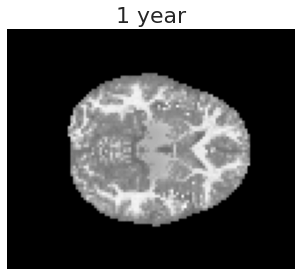

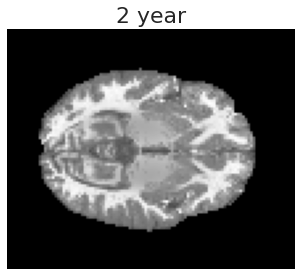

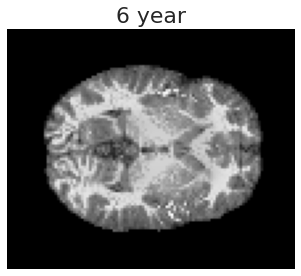

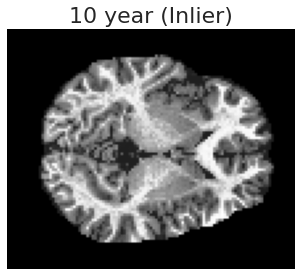

In [290]:
plt.grid(False)

for title, yr in zip(["1 year", "2 year", "6 year", "10 year (Inlier)"], [year1, year2, year6, year10]):
    plt.imshow(yr[10,...,-1], cmap="gray")
    plt.title(title, fontsize=22)
    plt.grid(False)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("../../Figures/{}.png".format(title), dpi=200, bbox_inches='tight')
    plt.show()
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off

## GMM

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.9s remaining:    3.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.5s finished


Best: 2.628691 using {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
---------------------------------------------------------------------------
2.628691 (0.512511) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}


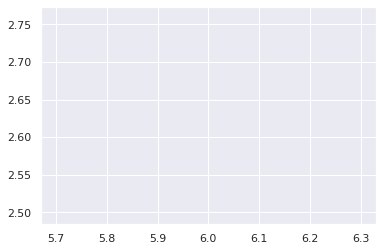

CPU times: user 2min 34s, sys: 1min 10s, total: 3min 45s
Wall time: 6.65 s


In [68]:
%%time
best_gmm_clf = train_gmm(X_train, components_range=range(6,7,1), verbose=True)

In [69]:
print("---Likelihoods---")
print("Training: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{}: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))

for name, ood in zip(LABELS[2:], outlier_scores):
    print("{}: {:.3f}".format(name, best_gmm_clf.score(ood)))

---Likelihoods---
Training: 2.792
Inlier: 1.242
1-2year: -16.413
4-6year: -9.855
8-10year: -4.744


In [70]:
%%time
gmm_train_score = best_gmm_clf.score_samples(X_train)
gmm_test_score = best_gmm_clf.score_samples(X_test)
# np.random.shuffle(gmm_test_score)
gmm_ood_scores = np.array([best_gmm_clf.score_samples(ood) for ood in outlier_scores])

CPU times: user 483 ms, sys: 881 ms, total: 1.36 s
Wall time: 36.5 ms


# OOD Evaluation

In [71]:
def get_metrics(test_score, ood_scores, **kwargs):
    metrics = {}
    for idx, _score in enumerate(ood_scores):
        ood_name = LABELS[idx+2]
        metrics[ood_name] = ood_metrics(test_score, _score, 
                                            names=(LABELS[1], ood_name))
    #     print()
    metrics_df = pd.DataFrame(metrics).T
    return metrics_df

In [72]:
X_train.shape

(10500, 10)

In [73]:
# for idx, _score in enumerate(ood_scores):
#     ood_metrics(-test_score, -_score, names=(LABELS[1], LABELS[idx+2]),
#                     plot=False, verbose=True)
#     print()

gmm_metrics = get_metrics(-gmm_test_score, -gmm_ood_scores)*100
gmm_metrics

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
1-2year,0.879507,0.921215,99.774799,99.778610,99.782199,0.351803,99.778712
4-6year,24.450308,9.799119,95.580899,95.734707,94.971146,2.286719,95.737189
8-10year,48.284960,18.885148,88.837043,80.784663,92.973946,17.854002,80.827972


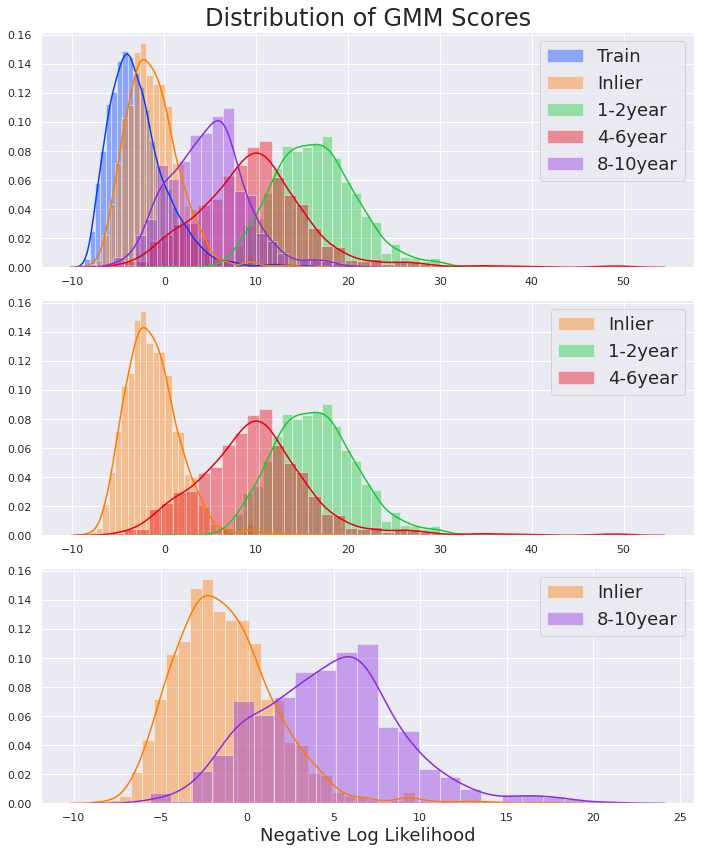

In [82]:
axs = evaluate_model(-gmm_train_score, -gmm_test_score, -gmm_ood_scores, labels=LABELS)
# for ax in axs:
#     ax.set(xlim = (-0.1,10.2))

axs[0].set(
    title=r"Distribution of GMM Scores",
)
axs[-1].set(
    xlabel="Negative Log Likelihood"
)
plt.legend()
plt.tight_layout()
plt.savefig("./gmm_scores.png", dpi=200)

In [81]:
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

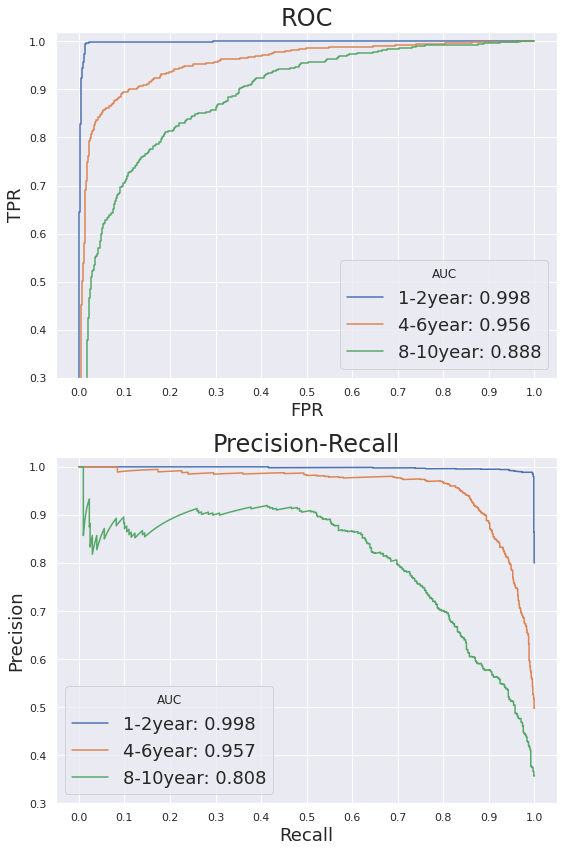

In [84]:
fig, axs = plt.subplots(2,1, figsize=(8,12))
for idx in range(0, len(outlier_scores)):
    plot_curves(-gmm_test_score, -gmm_ood_scores[idx], label=LABELS[idx+2], axs=axs)

for ax in axs:
    ax.legend(title="AUC")
    ax.set(ylim=(0.3, 1.02))
plt.tight_layout()
plt.savefig("./gmm_curves.png", dpi=200)

# Validation Check

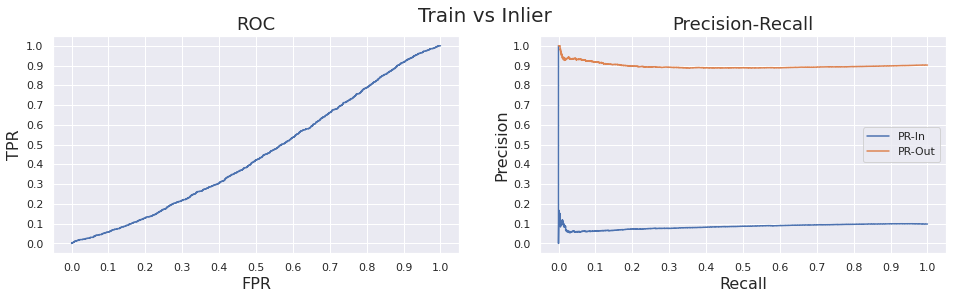

Train vs Inlier
----------------
ROC-AUC: 45.3590
PR-AUC (In/Out): 8.4756 / 89.7992
FPR (95% TPR): 92.95%
Detection Error: 48.96%


{'roc_auc': 0.4535902332788877,
 'fpr_tpr95': 0.9295238095238095,
 'fpr_tpr80': 0.8081904761904762,
 'pr_auc_in': 0.0847557962344021,
 'pr_auc_out': 0.8979918474692513,
 'ap': 0.0850678133512504,
 'de': 0.4896460610629476}

In [99]:
ood_metrics(-train_score, -test_score, names=(LABELS[0], LABELS[1]),plot=True, verbose=True)

### Flow Models

In [175]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [246]:
# X_train = 
X_train.shape

(10500, 10)

In [177]:
# Density estimation with MADE.
n = X_train.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[128, 128], activation="elu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob)

batch_size = 128
epochs = 1000
history = model.fit(
    x=X_train,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Epoch 1/1000
82/82 [==============================] - 0s 4ms/step - loss: 352283.5312
Epoch 2/1000
82/82 [==============================] - 0s 3ms/step - loss: 190667.4688
Epoch 3/1000
82/82 [==============================] - 0s 4ms/step - loss: 122505.6406
Epoch 4/1000
82/82 [==============================] - 0s 3ms/step - loss: 82713.2969
Epoch 5/1000
82/82 [==============================] - 0s 4ms/step - loss: 56931.4844
Epoch 6/1000
82/82 [==============================] - 0s 4ms/step - loss: 39713.1328
Epoch 7/1000
82/82 [==============================] - 0s 4ms/step - loss: 28001.8730
Epoch 8/1000
82/82 [==============================] - 0s 4ms/step - loss: 19914.9473
Epoch 9/1000
82/82 [==============================] - 0s 3ms/step - loss: 14327.1162
Epoch 10/1000
82/82 [==============================] - 0s 3ms/step - loss: 10485.3477
Epoch 11/1000
82/82 [======

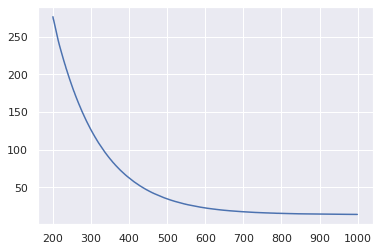

In [178]:
start_idx=200
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

In [247]:
%%time
flow_train_score = distribution.log_prob(X_train, dtype=np.float32).numpy()
flow_test_score = distribution.log_prob(X_test, dtype=np.float32).numpy()
flow_ood_scores = np.array([distribution.log_prob(ood, dtype=np.float32).numpy() for ood in outlier_scores])

CPU times: user 98.1 ms, sys: 16.4 ms, total: 114 ms
Wall time: 110 ms


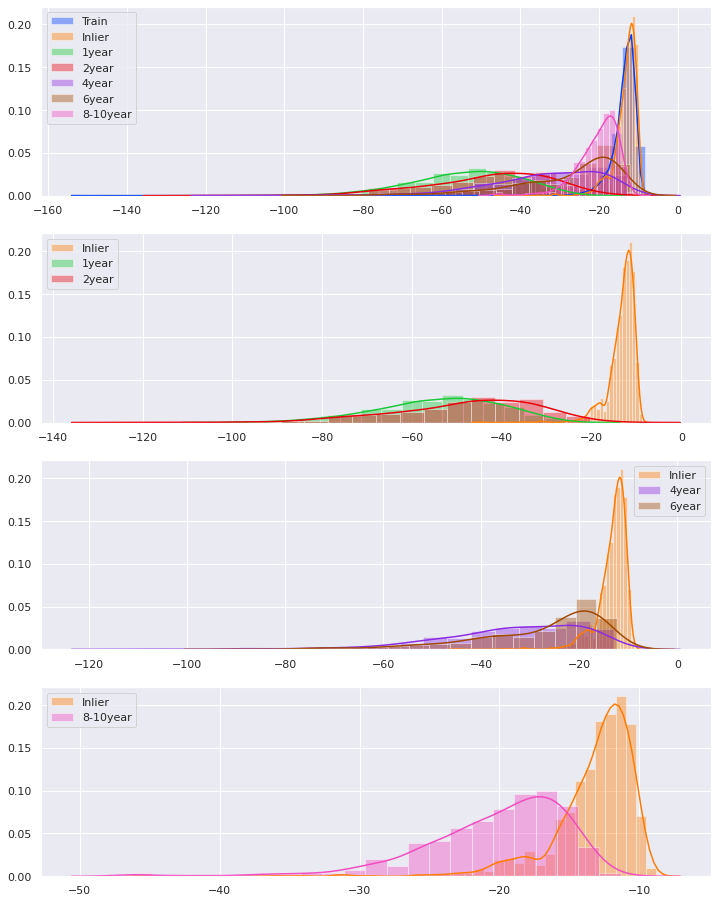

In [202]:
evaluate_model(flow_train_score, flow_test_score, flow_ood_scores, labels=LABELS)

In [248]:
flow_metrics = get_metrics(-flow_test_score, -flow_ood_scores)*100
flow_metrics

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
1year,0.263852,0.307828,99.955849,99.889647,99.981910,0.087951,99.889770
2year,0.791557,1.315655,99.753386,99.447126,99.893777,0.175901,99.447708
4year,12.225154,8.448725,97.320668,94.602601,98.805927,2.638522,94.608222
6year,28.935796,12.536675,94.371856,88.655789,97.506880,9.410730,88.668622
8-10year,26.561126,14.202902,92.065963,79.389922,96.695433,11.785400,79.461101


## KD Tree

In [19]:
from sklearn.neighbors import NearestNeighbors
N_NEIGHBOURS = 5

In [20]:
%%time
nbrs = NearestNeighbors(n_neighbors=N_NEIGHBOURS, algorithm='kd_tree').fit(X_train)

kd_train_score, indices = nbrs.kneighbors(X_train)

ood_dists = {}
kd_test_score, _ = nbrs.kneighbors(X_test)
kd_ood_scores = []
for name, ood in zip(ages, outlier_scores):
    dists, _ = nbrs.kneighbors(ood)
    kd_ood_scores.append(dists[...,-1])

CPU times: user 363 ms, sys: 5.19 ms, total: 368 ms
Wall time: 366 ms


In [21]:
# for name, dists in ood_dists.items():
#     ood_metrics(kd_test_score[:,-1], dists[:,-1], names=("CIFAR", name), plot=False, verbose=True)
#     print()
kd_metrics = get_metrics(kd_test_score[...,-1], kd_ood_scores) * 100
kd_metrics

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
1-2year,2.990325,2.884627,99.132719,99.002237,99.275386,1.231310,99.002823
4-6year,31.398417,13.184011,93.532672,93.326337,93.714246,8.531223,93.329990
8-10year,40.369393,16.096070,90.246132,82.248839,94.236922,12.928760,82.274529


In [22]:
def evaluate_model(train_score, inlier_score, outlier_scores, labels, ylim=None, xlim=None, **kwargs):
    rows = 1 + int(np.ceil(len(outlier_scores)/2))
    fig, axs = plt.subplots(rows, 1, figsize=(10,rows*4))
    axs = np.array(axs).reshape(-1) # Makes axs into list even if row num is 1
    colors = sns.color_palette("bright") + sns.color_palette("dark")
    
    sns.distplot(train_score, color=colors[0], label=labels[0], ax=axs[0], **kwargs)
    sns.distplot(inlier_score, color=colors[1], label=labels[1], ax=axs[0], **kwargs)
    
    offset = 2
    for idx, _score in enumerate(outlier_scores):
        idx += offset
        sns.distplot(_score, color=colors[idx], label=labels[idx], ax=axs[0], **kwargs)    

    # Plot in pairs    
    if len(outlier_scores) > 0 :
        offset = 0
        for row in range(1, axs.shape[0]):
            sns.distplot(inlier_score, color=colors[1], label=labels[1], ax=axs[row], **kwargs)
            
    #         for idx in range(offset, min(len(outlier_sc)offset+2)):
            for idx, _score in enumerate(outlier_scores[offset: offset+2]):
                idx += offset + 2
                sns.distplot(_score, color=colors[idx], label=labels[idx], ax=axs[row], **kwargs)    
            offset = 2 * row
        
    for ax in axs:
        ax.legend()
        ax.set_ylim(top=ylim)
        ax.set_xlim(left=xlim, right=100 if xlim else None)

#     plt.show()
    
    return axs

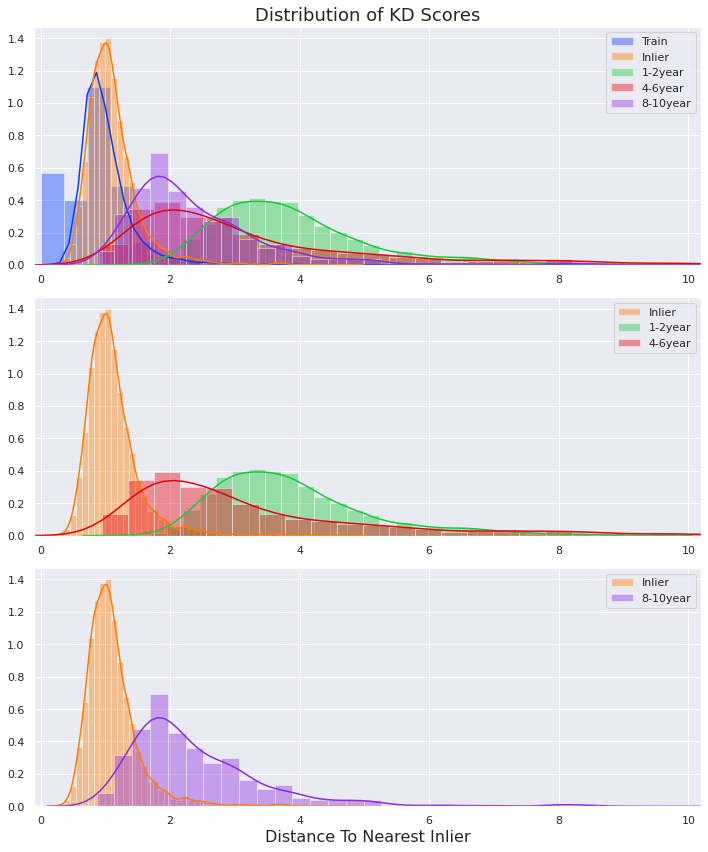

In [23]:
axs = evaluate_model(kd_train_score, kd_test_score, kd_ood_scores, labels=LABELS)

for ax in axs:
    ax.set(xlim = (-0.1,10.2))

axs[0].set(
    title=r"Distribution of KD Scores",
)
axs[-1].set(
    xlabel="Distance To Nearest Inlier"
)
plt.legend()
plt.tight_layout()
# plt.savefig("./kd_scores.png", dpi=200)

## Curves for each age range

In [251]:
for age, scores in zip(ages[:-1], gmm_ood_scores):
    print(age, scores.shape)

1year (500,)
2year (500,)
4year (500,)
6year (500,)
8year (500,)


1year (500,)
2year (500,)
4year (500,)
6year (500,)
8year (500,)


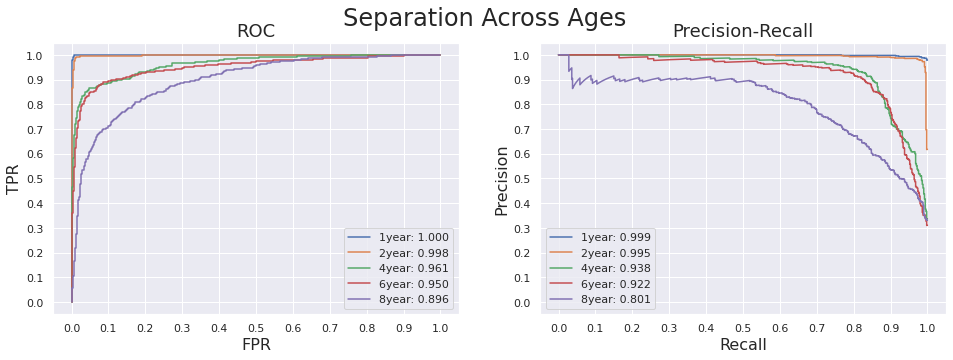

In [252]:
fig, axs = plt.subplots(1,2, figsize=(16,5))

for age, scores in zip(ages[:-1], gmm_ood_scores):
    print(age, scores.shape)
    plot_curves(-gmm_test_score, -scores, age, axs)
    
# for title, cifar_scores, svhn_scores in pairs:

#     plot_curves(cifar_scores, svhn_scores, title, axs)

# for ax in axs:
#     ax.set(ylim=(-0.01, 1.01), yticks=np.arange(-0.1, 1.01, step=0.1))
# axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Separation Across Ages",  fontsize=24)
# plt.savefig("../../Figures/brain_ages.png", dpi=200)